Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.4256
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2813 
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1566
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0636 
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━

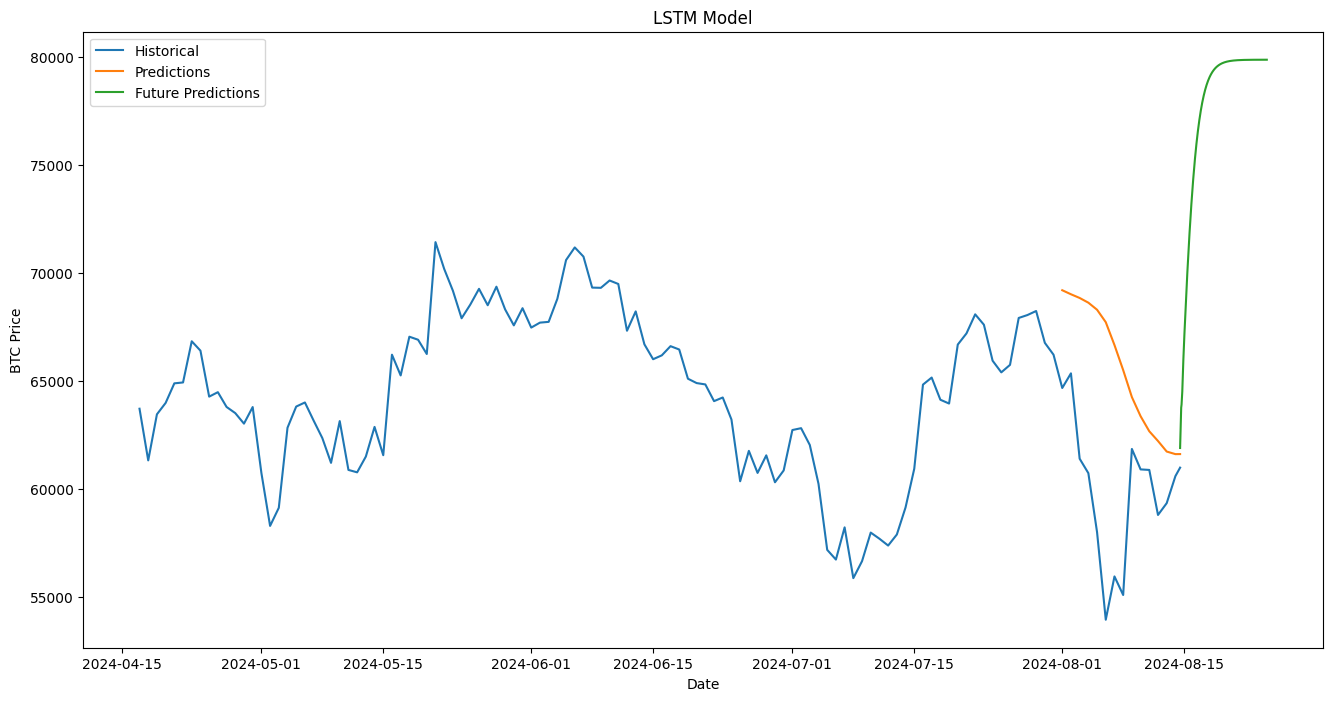

In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

def fetch_btc_data(days=120):
    """
    Fetches historical Bitcoin price data from CoinGecko API.

    Args:
        days (int): Number of days of historical data to fetch.

    Returns:
        pd.DataFrame: A DataFrame with timestamp as index and price as values.
    """
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days={days}"
    response = requests.get(url)
    data = response.json()
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

def preprocess_data(df, look_back=10):
    """
    Preprocesses the BTC price data for LSTM model training.

    Args:
        df (pd.DataFrame): The original DataFrame containing BTC prices.
        look_back (int): Number of previous time steps to use as input features.

    Returns:
        tuple: Scaled training and testing datasets, along with the scaler object.
    """
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['price'].values.reshape(-1, 1))

    # Split the data into training and testing sets
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    # Create datasets for LSTM
    def create_dataset(dataset, look_back):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    X_train, y_train = create_dataset(train_data, look_back)
    X_test, y_test = create_dataset(test_data, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler

def build_and_train_model(X_train, y_train, look_back=10, epochs=5, batch_size=64):
    """
    Builds and trains an LSTM model on the given dataset.

    Args:
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        look_back (int): Number of previous time steps to use as input features.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.

    Returns:
        Sequential: Trained LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

    return model

def predict_future(model, last_data, future_days=10, look_back=10, scaler=None):
    """
    Predicts future BTC prices using the trained LSTM model.

    Args:
        model (Sequential): Trained LSTM model.
        last_data (np.array): The last sequence of data to use as a starting point for prediction.
        future_days (int): Number of future days to predict.
        look_back (int): Number of previous time steps used as input features.
        scaler (MinMaxScaler): The scaler object used for data normalization.

    Returns:
        list: Predicted future BTC prices.
    """
    future_predictions = []
    current_data = last_data[-look_back:].copy()

    for _ in range(future_days * 24):  # Predict for each hour in future_days
        current_data_scaled = scaler.transform(current_data)
        X_current = current_data_scaled.reshape((1, look_back, 1))
        future_pred_scaled = model.predict(X_current)
        future_pred = scaler.inverse_transform(future_pred_scaled)
        future_predictions.append(future_pred[0, 0])
        current_data = np.append(current_data, future_pred, axis=0)[1:]

    return future_predictions

def plot_predictions(btc_data, valid, future_df):
    """
    Plots the historical, validation, and future predicted BTC prices.

    Args:
        btc_data (pd.DataFrame): Original BTC price data.
        valid (pd.DataFrame): Validation set with predictions.
        future_df (pd.DataFrame): Future predictions.
    """
    plt.figure(figsize=(16, 8))
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.plot(btc_data['price'], label='Historical')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.plot(future_df['Future Predictions'], label='Future Predictions')
    plt.legend()
    plt.show()

# Main Execution Flow

# Step 1: Fetch and preprocess data
btc_data = fetch_btc_data(120)
look_back = 10
X_train, y_train, X_test, y_test, scaler = preprocess_data(btc_data, look_back=look_back)

# Step 2: Build and train the LSTM model
model = build_and_train_model(X_train, y_train, look_back=look_back, epochs=5, batch_size=64)

# Step 3: Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Step 4: Prepare the validation set for plotting
valid = btc_data[len(btc_data) - len(X_test):].copy()
valid['Predictions'] = predictions

# Step 5: Predict future prices for the next 10 days
last_look_back_data = btc_data['price'].values[-look_back:].reshape(-1, 1)
future_prices = predict_future(model, last_look_back_data, future_days=10, look_back=look_back, scaler=scaler)

# Step 6: Prepare future predictions for plotting
future_dates = pd.date_range(start=btc_data.index[-1], periods=10*24, freq='H')  # 240 periods for 10 days
future_df = pd.DataFrame(future_prices, index=future_dates, columns=['Future Predictions'])

# Step 7: Plot historical data, validation predictions, and future predictions
plot_predictions(btc_data, valid, future_df)